# Detection Layer - 3-Label Classification

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
!pip install deslib
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI
from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap
!pip install scikit-posthocs
import scikit_posthocs as sp
from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier
!pip install scikit-optimize
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP
from sklearn.model_selection import RandomizedSearchCV

### Preparation before training

In [99]:
# Call Dataset
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('./3labelv4Classification.csv')
initial_df.info()
print("\nDataset shape:", initial_df.shape)
print("\nFirst few rows:")
print(initial_df.head())

# Check what appears to be the target column based on the CSV structure
target_candidates = ['BCaseControlStatus', 'label_encoded']
for col in target_candidates:
    if col in initial_df.columns:
        print(f"\nValue counts for {col}:")
        print(initial_df[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Columns: 134 entries, PtID to MULTIMODAL_COMPLETENESS
dtypes: bool(4), float64(83), int64(12), object(35)
memory usage: 203.0+ KB

Dataset shape: (199, 134)

First few rows:
   PtID DealHypoEp UndertreatHypo HighBGDamage FreqHypoDamage DangersHighBG  \
0     1   Disagree       Disagree     Disagree          Agree      Disagree   
1     2    Neutral       Disagree     Disagree        Neutral         Agree   
2     3   Disagree       Disagree     Disagree          Agree      Disagree   
3     4   Disagree          Agree        Agree          Agree         Agree   
4     5   Disagree       Disagree        Agree          Agree      Disagree   

   HighBGLevTakeAction  LowBGLevTakeAction  PtCurrA1cGoal  label_encoded  ...  \
0                170.0                80.0            8.0              0  ...   
1                175.0                80.0            6.8              1  ...   
2                200.0              

In [100]:
# Identify the target column - let's assume it's BCaseControlStatus based on the data structure
TARGET_COLUMN = 'BCaseControlStatus'  # Update this if your target is different

# Remove potential data leakage columns - these likely encode the target information
LEAKAGE_COLUMNS = [
    'label_encoded',  # This appears to be another encoding of the target
    'label_encoded_BMedChart', 
    'label_encoded_BSample',
    'label_encoded_BTOTSCORE',
    'label_encoded_depression',
    'label_encoded_fear',
    'label_encoded_lifestyle',
    'label_encoded_MOCA',
    'label_encoded_unaware'
]

# All categorical features except for target and leakage columns
cols = initial_df.columns
num_cols = initial_df._get_numeric_data().columns
categorical_features = list(set(cols) - set(num_cols))
if TARGET_COLUMN in categorical_features:
    categorical_features.remove(TARGET_COLUMN)

# Remove leakage columns from categorical features
for leak_col in LEAKAGE_COLUMNS:
    if leak_col in categorical_features:
        categorical_features.remove(leak_col)

print(f"Target column: {TARGET_COLUMN}")
print(f"Removed leakage columns: {LEAKAGE_COLUMNS}")
print(f"Number of categorical features: {len(categorical_features)}")
print(f"Number of numerical features: {len(num_cols)}")

# Label Encode all categorical features, but keep missing values
le_initial_df = initial_df.copy()

# Remove leakage columns entirely
for leak_col in LEAKAGE_COLUMNS:
    if leak_col in le_initial_df.columns:
        le_initial_df = le_initial_df.drop(leak_col, axis=1)
        print(f"Removed leakage column: {leak_col}")

dropped_labels = le_initial_df[TARGET_COLUMN]
le_initial_df = le_initial_df.drop(TARGET_COLUMN, axis=1)

for col in le_initial_df.columns:
    if le_initial_df[col].dtype == 'object':
        le_initial_df[col] = le_initial_df[col].fillna('missing')
        
        label_encoder = LabelEncoder()
        le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])
        
        missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]
        
        le_initial_df[col] = le_initial_df[col].replace(missing_value_index, np.nan)

le_initial_df = pd.concat([le_initial_df, dropped_labels], axis=1)

Target column: BCaseControlStatus
Removed leakage columns: ['label_encoded', 'label_encoded_BMedChart', 'label_encoded_BSample', 'label_encoded_BTOTSCORE', 'label_encoded_depression', 'label_encoded_fear', 'label_encoded_lifestyle', 'label_encoded_MOCA', 'label_encoded_unaware']
Number of categorical features: 34
Number of numerical features: 99
Removed leakage column: label_encoded
Removed leakage column: label_encoded_BMedChart
Removed leakage column: label_encoded_BSample
Removed leakage column: label_encoded_BTOTSCORE
Removed leakage column: label_encoded_depression
Removed leakage column: label_encoded_fear
Removed leakage column: label_encoded_lifestyle
Removed leakage column: label_encoded_MOCA
Removed leakage column: label_encoded_unaware


In [101]:
le_initial_df

,PtID,DealHypoEp,UndertreatHypo,HighBGDamage,FreqHypoDamage,DangersHighBG,HighBGLevTakeAction,LowBGLevTakeAction,PtCurrA1cGoal,LastFoodIntakeHrs_BMedChart,...,medications2_count,medications2_unique_values,medications2_text_length,medications2_word_count,HAS_TABULAR_DATA,HAS_TEXT_DATA,HAS_TIMESERIES_DATA,HAS_HEALTH_SURVEY,MULTIMODAL_COMPLETENESS,BCaseControlStatus
0,1,1,1,1,0,1,170.0,80.0,8.0,2.0,...,1.0,11.0,723.0,138.0,True,True,True,True,1.0,Case
1,2,2,1,1,2,0,175.0,80.0,6.8,2.0,...,1.0,11.0,783.0,148.0,True,True,True,True,1.0,Control
2,3,1,1,1,0,1,200.0,70.0,7.9,2.0,...,1.0,11.0,867.0,162.0,True,True,True,True,1.0,Control
3,4,1,0,0,0,0,140.0,65.0,5.4,2.0,...,1.0,11.0,867.0,162.0,True,True,True,True,1.0,Control
4,5,1,1,0,0,1,100.0,70.0,5.0,2.0,...,1.0,11.0,998.0,185.0,True,True,True,True,1.0,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,199,0,0,0,0,0,200.0,70.0,6.5,2.0,...,1.0,11.0,849.0,159.0,True,True,True,True,1.0,Case
195,200,0,1,0,0,1,150.0,90.0,7.0,2.0,...,1.0,11.0,873.0,165.0,True,True,True,True,1.0,Case
196,201,1,1,1,0,1,250.0,50.0,6.0,2.0,...,1.0,11.0,789.0,151.0,True,True,True,True,1.0,Case
197,202,1,1,1,0,1,200.0,95.0,7.0,2.0,...,1.0,11.0,897.0,169.0,True,True,True,True,1.0,Case


In [102]:
# Check target distribution and prepare data accordingly
print("Target column distribution:")
print(le_initial_df[TARGET_COLUMN].value_counts())

# If this is a binary classification, we can proceed directly
# If it's multi-class, we might want to combine classes or handle differently
unique_targets = le_initial_df[TARGET_COLUMN].unique()
print(f"\nUnique target values: {unique_targets}")

# For this example, let's assume we want to keep all classes as-is
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Target column distribution:
Control    100
Case        99
Name: BCaseControlStatus, dtype: int64

Unique target values: ['Case' 'Control']

Target distribution:
Class Control: 100 samples
Class Case: 99 samples


In [103]:
# Remove outliers - samples with too many missing values
threshold = int(0.8 * le_initial_df.shape[1])
print(f"Removing samples with more than {le_initial_df.shape[1] - threshold} missing values")

before_count = len(le_initial_df)
le_initial_df = le_initial_df.dropna(thresh=threshold)
after_count = len(le_initial_df)

print(f"Samples before: {before_count}")
print(f"Samples after: {after_count}")
print(f"Removed: {before_count - after_count} samples")

# Check target distribution after removal
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution after outlier removal:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Removing samples with more than 25 missing values
Samples before: 199
Samples after: 199
Removed: 0 samples

Target distribution after outlier removal:
Class Control: 100 samples
Class Case: 99 samples


In [104]:
# Imputation
print("Performing imputation...")
y = le_initial_df[TARGET_COLUMN]
X = le_initial_df.drop(TARGET_COLUMN, axis=1)

imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(X)
imputed_df = pd.DataFrame(imputed_data, columns=X.columns)

concatenated_le_dfs = pd.concat([imputed_df, y.reset_index(drop=True)], axis=1)
print("Imputation completed")
print(f"Final dataset shape: {concatenated_le_dfs.shape}")

Performing imputation...
Imputation completed
Final dataset shape: (199, 125)


In [105]:
# Full label encode target column if it's not already numeric
fully_LE_concatenated_le_dfs = concatenated_le_dfs.copy()

if fully_LE_concatenated_le_dfs[TARGET_COLUMN].dtype == 'object':
    label_encoder = LabelEncoder()
    fully_LE_concatenated_le_dfs[TARGET_COLUMN] = label_encoder.fit_transform(fully_LE_concatenated_le_dfs[TARGET_COLUMN])
    print("Target column label encoded")
    print("Label mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {i}: {label}")

# The dataset after preprocessing
splitted_dataset = fully_LE_concatenated_le_dfs.copy()
print(f"\nFinal preprocessed dataset shape: {splitted_dataset.shape}")
print(f"Target distribution:")
print(splitted_dataset[TARGET_COLUMN].value_counts().sort_index())

Target column label encoded
Label mapping:
  0: Case
  1: Control

Final preprocessed dataset shape: (199, 125)
Target distribution:
0     99
1    100
Name: BCaseControlStatus, dtype: int64


### Setup for training

In [106]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))

    for i, clf_name in enumerate(classifier_names):
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', marker='o', markersize=4,
                 label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="lower right", fontsize=22, frameon=True, framealpha=0.9)
    plt.grid(True)

    filename='bonk.svg'

    plt.savefig(filename, format='svg')
    plt.show()

    display(FileLink(filename))

# Preparation code to make CD diagram from older version of Orange
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.

    This function is deprecated and will be removed in Orange 3.34.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    This function is deprecated and will be removed in Orange 3.34.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, fontsize = 14, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

def train_evaluate_model(clf, X_train, y_train, X_test, y_test, clf_name='Classifier'):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # For multi-class ROC, we'll use macro-average
    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_test)
        if y_score.shape[1] == 2:  # Binary classification
            y_score = y_score[:, 1]
        else:  # Multi-class - use the probability of the positive class or max probability
            y_score = np.max(y_score, axis=1)
    else:
        y_score = clf.decision_function(X_test)
        if len(y_score.shape) > 1:
            y_score = np.max(y_score, axis=1)

    # For multi-class, we'll compute ROC for binary case (class 1 vs rest)
    y_test_binary = (y_test == 1).astype(int)
    y_score_binary = y_score
    
    try:
        fpr, tpr, _ = roc_curve(y_test_binary, y_score_binary)
        roc_auc = auc(fpr, tpr)
    except:
        # Fallback for cases where ROC can't be computed
        fpr, tpr, roc_auc = [0, 1], [0, 1], 0.5

    print(f'{clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    return accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc

In [107]:
warnings.filterwarnings('ignore')

### Training (classic/static)
In order to run classical/static, make sure to uncomment the one you need. "Post Training" is after one of these classical/static is done.

#### Classical Classifiers

In [108]:
#Optimized Classifiers
classifiers = {
     'DT': DecisionTreeClassifier(
         random_state=0,
         criterion='gini',
         max_depth=6,
         min_samples_leaf=10,
         min_samples_split=9
     ),
     'LR': LogisticRegression(
         random_state=0,
         C=0.09659168435718246,
         max_iter=100,
         solver='lbfgs'
     ),
     'NB': GaussianNB(
         var_smoothing=0.0058873326349240295
     ),
     'KN': KNeighborsClassifier(
         metric='manhattan',
         n_neighbors=8,
         weights='uniform'
     ),
     'MLP': MLPClassifier(
         random_state=0,
         max_iter=1000,
         alpha=0.0003079393718075164,
         hidden_layer_sizes=195,
         learning_rate_init=0.0001675266159417717
     ),
     'SVC': SVC(probability=True, kernel = 'rbf', C = 0.95, gamma = 'scale')}

# Initialize
metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices = defaultdict(list)
roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)

# Loop over 10 different random states
for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    # Splitting the data - use the target column we identified
    X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
    y = splitted_dataset[TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    # Identify outliers in the training dataset
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    # Select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    # Handle class imbalance with SMOTE (adjust for multi-class)
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {Counter(y_res)}")
    print(f"Number of test labels: {Counter(y_test)}")

    # Normalization
    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    # Improved Feature Selection - use RandomForest for feature importance
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=random_state, max_depth=10)
    rf_selector.fit(X_res, y_res)
    
    # Get feature importance and select top features
    feature_importance = rf_selector.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    
    # Select top 30 features instead of 50 to avoid overfitting
    top_features = [original_columns[i] for i in indices[:30]]
    
    print(f"Top 10 features: {top_features[:10]}")

    # Only take top features
    X_res_fi = X_res[top_features]
    X_test_fi = X_test[top_features]

    # Evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Ensure the random state for classifiers is consistent
        if hasattr(clf, 'random_state'):
            clf.set_params(random_state=random_state)
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums[clf_name]['accuracy'] += accuracy
        metric_sums[clf_name]['precision'] += precision
        metric_sums[clf_name]['recall'] += recall
        metric_sums[clf_name]['f1'] += f1
        conf_matrices[clf_name].append(conf_matrix)
        roc_curves[clf_name].append((fpr, tpr))
        roc_aucs[clf_name].append(roc_auc)
        accuracy_scores[clf_name].append(accuracy)
        precision_scores[clf_name].append(precision)
        recall_scores[clf_name].append(recall)
        f1_scores[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: Counter({1: 65, 0: 65})
Number of test labels: Counter({0: 30, 1: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'Height_mod_BMedChart', 'SymbDigWTotCorr_BTOTSCORE', 'FeelSympLowBG_unaware', 'SymbDigOTotCorr_BTOTSCORE', 'medications2_word_count', 'medications2_text_length', 'LowBGSympCat_unaware', 'WorryNotRecLowBG_fear', 'GrPegDomTotTime_BTOTSCORE']
DT - Accuracy: 0.7833, Precision: 0.7862, Recall: 0.7833, F1-Score: 0.7828
LR - Accuracy: 0.7833, Precision: 0.7862, Recall: 0.7833, F1-Score: 0.7828
NB - Accuracy: 0.8500, Precision: 0.8504, Recall: 0.8500, F1-Score: 0.8500
KN - Accuracy: 0.7500, Precision: 0.7644, Recall: 0.7500, F1-Score: 0.7466
Top 10 features: ['SevHypoEpPastYear_unaware', 'Height_mod_BMedChart', 'SymbDigWTotCorr_BTOTSCORE', 'FeelSympLowBG_unaware', 'SymbDigOTotCorr_BTOTSCORE', 'medications2_word_count', 'medications2_text_length', 'LowBGSympCat_unaware', 'WorryNotRecLowBG_fear', 'GrPegDomTotTi

#### Static Classifiers

In [109]:
# Initialize
metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices = defaultdict(list)
roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)

# Optimized Classifiers
classifiers = {
    'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
    'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=0),
    'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05),
}

# Define the number of features for each classifier - reduced to avoid overfitting
num_features = {
     'RF': 30,
     'XGB': 25,
     'GB': 25,
}

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
    y = splitted_dataset[TARGET_COLUMN]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {Counter(y_res)}")
    print(f"Number of test labels: {Counter(y_test)}")

    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    # Improved feature selection using RandomForest instead of correlation
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=random_state, max_depth=10)
    rf_selector.fit(X_res, y_res)
    feature_importance = rf_selector.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    
    for clf_name, clf in classifiers.items():
        num_top_features = num_features[clf_name]
        top_features = [original_columns[i] for i in indices[:num_top_features]]

        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
        )
        metric_sums[clf_name]['accuracy'] += accuracy
        metric_sums[clf_name]['precision'] += precision
        metric_sums[clf_name]['recall'] += recall
        metric_sums[clf_name]['f1'] += f1
        conf_matrices[clf_name].append(conf_matrix)
        roc_curves[clf_name].append((fpr, tpr))
        roc_aucs[clf_name].append(roc_auc)
        accuracy_scores[clf_name].append(accuracy)
        precision_scores[clf_name].append(precision)
        recall_scores[clf_name].append(recall)
        f1_scores[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: Counter({1: 65, 0: 65})
Number of test labels: Counter({0: 30, 1: 30})
RF - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166
RF - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166
XGB - Accuracy: 0.7167, Precision: 0.7189, Recall: 0.7167, F1-Score: 0.7160
XGB - Accuracy: 0.7167, Precision: 0.7189, Recall: 0.7167, F1-Score: 0.7160
GB - Accuracy: 0.8500, Precision: 0.8535, Recall: 0.8500, F1-Score: 0.8496
Processing for Random State: 1
Number of training labels after SMOTE: Counter({1: 64, 0: 64})
Number of test labels: Counter({0: 30, 1: 30})
GB - Accuracy: 0.8500, Precision: 0.8535, Recall: 0.8500, F1-Score: 0.8496
Processing for Random State: 1
Number of training labels after SMOTE: Counter({1: 64, 0: 64})
Number of test labels: Counter({0: 30, 1: 30})
RF - Accuracy: 0.7667, Precision: 0.7667, Recall: 0.7667, F1-Score: 0.7667
RF - Accuracy: 0.7667, Precision: 0.7667, Recall: 

### Post Training (classic/static)
Only run after one of the training methods above are done

In [110]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores[clf_name])
    std_precision = np.std(precision_scores[clf_name])
    std_recall = np.std(recall_scores[clf_name])
    std_f1 = np.std(f1_scores[clf_name])
    avg_auc = np.mean(roc_aucs[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')


Average Metrics over 10 Random States:
RF - Accuracy: 0.7750 ± 0.0352, Precision: 0.7804 ± 0.0367, Recall: 0.7750 ± 0.0352, F1-Score: 0.7740 ± 0.0353, AUC: 0.8729
XGB - Accuracy: 0.7550 ± 0.0289, Precision: 0.7601 ± 0.0285, Recall: 0.7550 ± 0.0289, F1-Score: 0.7537 ± 0.0295, AUC: 0.8508
GB - Accuracy: 0.8050 ± 0.0248, Precision: 0.8133 ± 0.0234, Recall: 0.8050 ± 0.0248, F1-Score: 0.8036 ± 0.0257, AUC: 0.8619


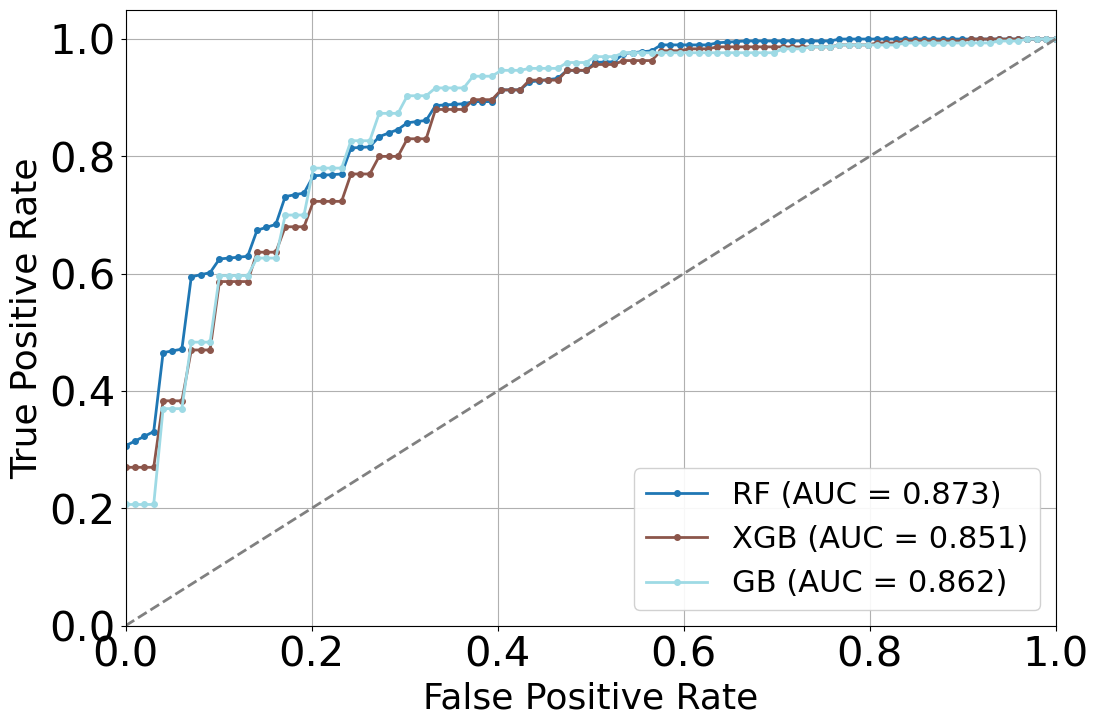

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

In [111]:
# Plot ROC Curves for each classifier in one graph
plot_combined_roc_curve(roc_curves, classifiers.keys())

Friedman Test Statistic: 12.66666666666666, p-value: 0.001776103545734384
Critical Difference: 1.0481349509868467


<Figure size 1400x800 with 0 Axes>

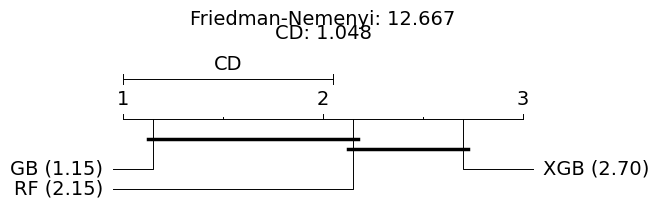

In [112]:
# FN Curve
df = pd.DataFrame(accuracy_scores)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

### Hyperparameter optimization (classic/static)

In [ ]:
# Hyperparameter optimization classic
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import numpy as np

# Fix for np.int error - create this function to patch any integer values
def fix_integer_params(search_space):
    fixed_space = {}
    for key, value in search_space.items():
        if isinstance(value, list) and all(isinstance(x, (int, float)) for x in value):
            fixed_space[key] = value  # Lists of numeric values are fine
        elif isinstance(value, Integer):
            # No changes needed for Integer objects from skopt
            fixed_space[key] = value
        else:
            fixed_space[key] = value
    return fixed_space

search_spaces = {
    'DecisionTree': {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(1, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10)
    },
    'LogisticRegression': {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'solver': Categorical(['lbfgs', 'liblinear']),
        'max_iter': Integer(100, 1000)
    },
    'NaiveBayes': {
        'var_smoothing': Real(1e-9, 1e-2, prior='log-uniform')
    },
    'KNeighbors': {
        'n_neighbors': Integer(1, 30),
        'weights': Categorical(['uniform', 'distance']),
        'metric': Categorical(['euclidean', 'manhattan', 'minkowski'])
    },
    'MLP': {
        'hidden_layer_sizes': Integer(50, 200),
        'alpha': Real(1e-6, 1e-2, prior='log-uniform'),
        'learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
    },
    'SVC': {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
}

# Apply the fix to each search space
for clf_name in search_spaces:
    search_spaces[clf_name] = fix_integer_params(search_spaces[clf_name])

classifiers = {
    'DecisionTree': DecisionTreeClassifier(random_state=0),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=0),
    'NaiveBayes': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=0),
    'SVC': SVC(probability=True, random_state=0)
}

top_features_count = {
    'DecisionTree': 200,
    'LogisticRegression': 200,
    'NaiveBayes': 200,
    'KNeighbors': 200,
    'MLP': 200,
    'SVC': 200
}

random_state = 0
print(f"Processing for Random State: {random_state}")

X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
y = splitted_dataset[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

smote = SMOTE(random_state=random_state)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"Number of training labels after SMOTE: {Counter(y_res)}")
print(f"Number of test labels: {Counter(y_test)}")

scaler = MinMaxScaler()

X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

X_res = pd.DataFrame(X_res, columns=original_columns)
X_test = pd.DataFrame(X_test, columns=original_columns)

log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
log_reg.fit(X_res, y_res)
selector = SelectFromModel(log_reg, prefit=True)

importance = np.abs(log_reg.coef_[0])
indices = np.argsort(importance)[::-1]
important_features = [original_columns[i] for i in indices[:300]]

for clf_name, clf in classifiers.items():
    num_top_features = top_features_count[clf_name]
    selected_features = important_features[:num_top_features]

    X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
    X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]

    accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
        clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
    )
    metric_sums[clf_name]['accuracy'] += accuracy
    metric_sums[clf_name]['precision'] += precision
    metric_sums[clf_name]['recall'] += recall
    metric_sums[clf_name]['f1'] += f1
    conf_matrices[clf_name].append(conf_matrix)
    roc_curves[clf_name].append((fpr, tpr))
    roc_aucs[clf_name].append(roc_auc)
    accuracy_scores[clf_name].append(accuracy)
    precision_scores[clf_name].append(precision)
    recall_scores[clf_name].append(recall)
    f1_scores[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: Counter({1: 65, 0: 65})
Number of test labels: Counter({0: 30, 1: 30})
DecisionTree - Accuracy: 0.7833, Precision: 0.7914, Recall: 0.7833, F1-Score: 0.7818
LogisticRegression - Accuracy: 0.7333, Precision: 0.7376, Recall: 0.7333, F1-Score: 0.7321
NaiveBayes - Accuracy: 0.6667, Precision: 0.6697, Recall: 0.6667, F1-Score: 0.6652
Number of training labels after SMOTE: Counter({1: 65, 0: 65})
Number of test labels: Counter({0: 30, 1: 30})
DecisionTree - Accuracy: 0.7833, Precision: 0.7914, Recall: 0.7833, F1-Score: 0.7818
LogisticRegression - Accuracy: 0.7333, Precision: 0.7376, Recall: 0.7333, F1-Score: 0.7321
NaiveBayes - Accuracy: 0.6667, Precision: 0.6697, Recall: 0.6667, F1-Score: 0.6652
KNeighbors - Accuracy: 0.6667, Precision: 0.6984, Recall: 0.6667, F1-Score: 0.6528
KNeighbors - Accuracy: 0.6667, Precision: 0.6984, Recall: 0.6667, F1-Score: 0.6528
MLP - Accuracy: 0.7333, Precision: 0.7431, Recall: 0.7333, F1-Sco

In [115]:
# Update static hyperparameter optimization to use the new target column
metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices = defaultdict(list)
roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)

import numpy as np
if not hasattr(np, 'int'):
    np.int = int


classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    #'LightGBM': LGBMClassifier()
}

num_features = {
     'RandomForest': 150,
     'XGBoost': 150,
     'GradientBoosting': 150,
     'AdaBoost': 150,
     'CatBoost': 150,
     #'LightGBM': 150,
}

search_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10],
        'subsample': [0.7, 0.9, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    #'LightGBM': {
    #    'n_estimators': [100, 200, 300],
    #    'num_leaves': [31, 63, 127],
    #    'learning_rate': [0.01, 0.1, 0.2],
    #    'subsample': [0.7, 0.9, 1.0],
    #}
}

def hyperparameter_optimization(clf, search_space, X, y):
    combined_results = []
    for random_state in range(3):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
        opt.fit(X, y)
        combined_results.append(opt.best_params_)
    best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
    return best_params

for random_state in range(9,10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
    y = splitted_dataset[TARGET_COLUMN]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {Counter(y_res)}")
    print(f"Number of test labels: {Counter(y_test)}")

    scaler = MinMaxScaler()

    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)
    
    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices[:300]]

    for clf_name, clf in classifiers.items():
        print(f"Optimizing {clf_name}")
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]
        
        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
        
        best_params = hyperparameter_optimization(clf, search_spaces[clf_name], X_res_fi, y_res)
        if 'n_estimators' in best_params:
            best_params['n_estimators'] = int(best_params['n_estimators'])
        if 'max_depth' in best_params:
            best_params['max_depth'] = int(best_params['max_depth'])
        if 'iterations' in best_params:
            best_params['iterations'] = int(best_params['iterations'])
        if 'num_leaves' in best_params:
            best_params['num_leaves'] = int(best_params['num_leaves'])
        clf.set_params(**best_params)
        print(f"Best parameters for {clf_name}: {best_params}")

        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums[clf_name]['accuracy'] += accuracy
        metric_sums[clf_name]['precision'] += precision
        metric_sums[clf_name]['recall'] += recall
        metric_sums[clf_name]['f1'] += f1
        conf_matrices[clf_name].append(conf_matrix)
        roc_curves[clf_name].append((fpr, tpr))
        roc_aucs[clf_name].append(roc_auc)
        accuracy_scores[clf_name].append(accuracy)
        precision_scores[clf_name].append(precision)
        recall_scores[clf_name].append(recall)
        f1_scores[clf_name].append(f1)

Processing for Random State: 9
Number of training labels after SMOTE: Counter({0: 65, 1: 65})
Number of test labels: Counter({1: 30, 0: 30})
Optimizing RandomForest
Best parameters for RandomForest: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
RandomForest - Accuracy: 0.8333, Precision: 0.8472, Recall: 0.8333, F1-Score: 0.8316
Optimizing XGBoost
Best parameters for XGBoost: {'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
XGBoost - Accuracy: 0.7667, Precision: 0.8175, Recall: 0.7667, F1-Score: 0.7569
Optimizing AdaBoost
Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost - Accuracy: 0.7667, Precision: 0.8175, Recall: 0.7667, F1-Score: 0.7569
Optimizing GradientBoosting
Best parameters for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
GradientBoosting - Accuracy: 0.7667, Precision: 0.8175, Recall: 0.7667, F1-Score: 0.7569
Opt

In [117]:
import numpy as np
if not hasattr(np, 'float'):
    np.float = float

metric_sums_des = {
    'KNORAE': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNORAU': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESMI': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-U': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-E': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
}

conf_matrices_des = {
    'KNORAE': [],
    'KNORAU': [],
    'KNOP': [],
    'DESMI': [],
    'METADES': [],
    'DESKNN': [],
    'DESP': [],
    'FIRE-KNORA-U': [],
    'FIRE-KNORA-E': [],
    'FIRE-METADES': [],
    'FIRE-DESKNN': [],
    'FIRE-DESP': [],
    'FIRE-KNOP': [],
}

roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)
feature_importance_runs = []

# Add multiple classifiers for DES to work properly - DES requires at least 2-3 classifiers
base_classifiers = {
    'DecisionTree': DecisionTreeClassifier(
        random_state=0,
        criterion='gini',
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=9
    ),
    'LogisticRegression': LogisticRegression(
        random_state=0,
        C=0.09659168435718246,
        max_iter=100,
        solver='lbfgs'
    ),
    'NaiveBayes': GaussianNB(
        var_smoothing=0.0058873326349240295
    ),
    'KNeighbors': KNeighborsClassifier(
        metric='manhattan',
        n_neighbors=15,
        weights='uniform'
    ),
    'MLP': MLPClassifier(
        random_state=0,
        max_iter=1000,
        alpha=0.0003079393718075164,
        hidden_layer_sizes=195,
        learning_rate_init=0.0001675266159417717
    ),
    'SVC': SVC(probability=True, kernel = 'rbf', C = 1.5, gamma = 'auto'),
    'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
    'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=0),
    'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05),
    'AB': AdaBoostClassifier(n_estimators=400, learning_rate=0.1),
    'CB': CatBoostClassifier(depth = 3, iterations = 168, learning_rate = 0.1, verbose = 0),
    # 'LGBM': LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 200)
}

random_state = 0

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
    y = splitted_dataset[TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {Counter(y_res)}")
    print(f"Number of test labels: {Counter(y_test)}")

    scaler = MinMaxScaler()

    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    xgb_fs = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs.fit(X_res, y_res)

    feature_importances = xgb_fs.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    top_50_features = [original_columns[i] for i in indices[:50]]
    current_run_features = {original_columns[i]: feature_importances[i] for i in indices[:50]}

    feature_importance_runs.append(current_run_features)

    X_res_fi = X_res[top_50_features]
    X_test_fi = X_test[top_50_features]

    model_pool = list(base_classifiers.values())
    
    print(f"Training {len(model_pool)} base classifiers...")

    for clf in model_pool:
        clf.fit(X_res_fi, y_res)

    des_models = {
        'KNORAE': KNORAE(pool_classifiers=model_pool, random_state=random_state),
        'KNORAU': KNORAU(pool_classifiers=model_pool, random_state=random_state),
        'DESMI': DESMI(pool_classifiers=model_pool, random_state=random_state),
        'METADES': METADES(pool_classifiers=model_pool, random_state=random_state),
        'DESKNN': DESKNN(pool_classifiers=model_pool, random_state=random_state),
        'DESP': DESP(pool_classifiers=model_pool, random_state=random_state),
        'KNOP': KNOP(pool_classifiers=model_pool, random_state=random_state, k=9),
        'FIRE-KNORA-U': KNORAU(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-KNORA-E': KNORAE(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-METADES': METADES(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-DESKNN': DESKNN(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-DESP': DESP(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-KNOP': KNOP(pool_classifiers=model_pool, DFP=True, k=40, random_state = random_state)
    }

    for des_name, des_model in des_models.items():
        try:
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                des_model, X_res_fi, y_res, X_test_fi, y_test, clf_name=des_name
            )
            metric_sums_des[des_name]['accuracy'] += accuracy
            metric_sums_des[des_name]['precision'] += precision
            metric_sums_des[des_name]['recall'] += recall
            metric_sums_des[des_name]['f1'] += f1
            conf_matrices_des[des_name].append(conf_matrix)
            roc_curves[des_name].append((fpr, tpr))
            roc_aucs[des_name].append(roc_auc)
            accuracy_scores[des_name].append(accuracy)
            precision_scores[des_name].append(precision)
            recall_scores[des_name].append(recall)
            f1_scores[des_name].append(f1)

            print(f'Confusion Matrix for {des_name} at Random State {random_state}:\n{conf_matrix}\n')
        except Exception as e:
            print(f"Error with {des_name}: {e}")
            # Add placeholder values to maintain consistency
            metric_sums_des[des_name]['accuracy'] += 0.0
            metric_sums_des[des_name]['precision'] += 0.0
            metric_sums_des[des_name]['recall'] += 0.0
            metric_sums_des[des_name]['f1'] += 0.0
            accuracy_scores[des_name].append(0.0)
            precision_scores[des_name].append(0.0)
            recall_scores[des_name].append(0.0)
            f1_scores[des_name].append(0.0)
            continue

Processing for Random State: 0
Number of training labels after SMOTE: Counter({1: 65, 0: 65})
Number of test labels: Counter({0: 30, 1: 30})
Training 11 base classifiers...
Training 11 base classifiers...
KNORAE - Accuracy: 0.7667, Precision: 0.7715, Recall: 0.7667, F1-Score: 0.7656
Confusion Matrix for KNORAE at Random State 0:
[[21  9]
 [ 5 25]]

KNORAE - Accuracy: 0.7667, Precision: 0.7715, Recall: 0.7667, F1-Score: 0.7656
Confusion Matrix for KNORAE at Random State 0:
[[21  9]
 [ 5 25]]

KNORAU - Accuracy: 0.7500, Precision: 0.7571, Recall: 0.7500, F1-Score: 0.7483
Confusion Matrix for KNORAU at Random State 0:
[[20 10]
 [ 5 25]]

KNORAU - Accuracy: 0.7500, Precision: 0.7571, Recall: 0.7500, F1-Score: 0.7483
Confusion Matrix for KNORAU at Random State 0:
[[20 10]
 [ 5 25]]

DESMI - Accuracy: 0.8000, Precision: 0.8054, Recall: 0.8000, F1-Score: 0.7991
Confusion Matrix for DESMI at Random State 0:
[[22  8]
 [ 4 26]]

DESMI - Accuracy: 0.8000, Precision: 0.8054, Recall: 0.8000, F1-Sco

In [118]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))

    for i, clf_name in enumerate(classifier_names):
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', marker='o', markersize=4,
                 label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=26, frameon=True, framealpha=0.9)  # Place legend beside the plot
    plt.grid(True)

    filename='bonk.svg'

    plt.savefig(filename, format='svg', bbox_inches = 'tight')
    plt.show()

    display(FileLink(filename))


Average Metrics over 10 Random States:
KNORAE - Accuracy: 0.7733 ± 0.0327, Precision: 0.7799 ± 0.0371, Recall: 0.7733 ± 0.0327, F1-Score: 0.7722 ± 0.0324, AUC: 0.8756
KNORAU - Accuracy: 0.7700 ± 0.0393, Precision: 0.7770 ± 0.0444, Recall: 0.7700 ± 0.0393, F1-Score: 0.7688 ± 0.0390, AUC: 0.8304
KNOP - Accuracy: 0.7750 ± 0.0291, Precision: 0.7821 ± 0.0347, Recall: 0.7750 ± 0.0291, F1-Score: 0.7738 ± 0.0288, AUC: 0.7967
DESMI - Accuracy: 0.7750 ± 0.0359, Precision: 0.7812 ± 0.0406, Recall: 0.7750 ± 0.0359, F1-Score: 0.7740 ± 0.0357, AUC: 0.8766
METADES - Accuracy: 0.7750 ± 0.0291, Precision: 0.7820 ± 0.0331, Recall: 0.7750 ± 0.0291, F1-Score: 0.7737 ± 0.0291, AUC: 0.8798
DESKNN - Accuracy: 0.7650 ± 0.0398, Precision: 0.7717 ± 0.0448, Recall: 0.7650 ± 0.0398, F1-Score: 0.7638 ± 0.0394, AUC: 0.8781
DESP - Accuracy: 0.7717 ± 0.0373, Precision: 0.7789 ± 0.0423, Recall: 0.7717 ± 0.0373, F1-Score: 0.7704 ± 0.0371, AUC: 0.8784
FIRE-KNORA-U - Accuracy: 0.7767 ± 0.0351, Precision: 0.7837 ± 0.0405

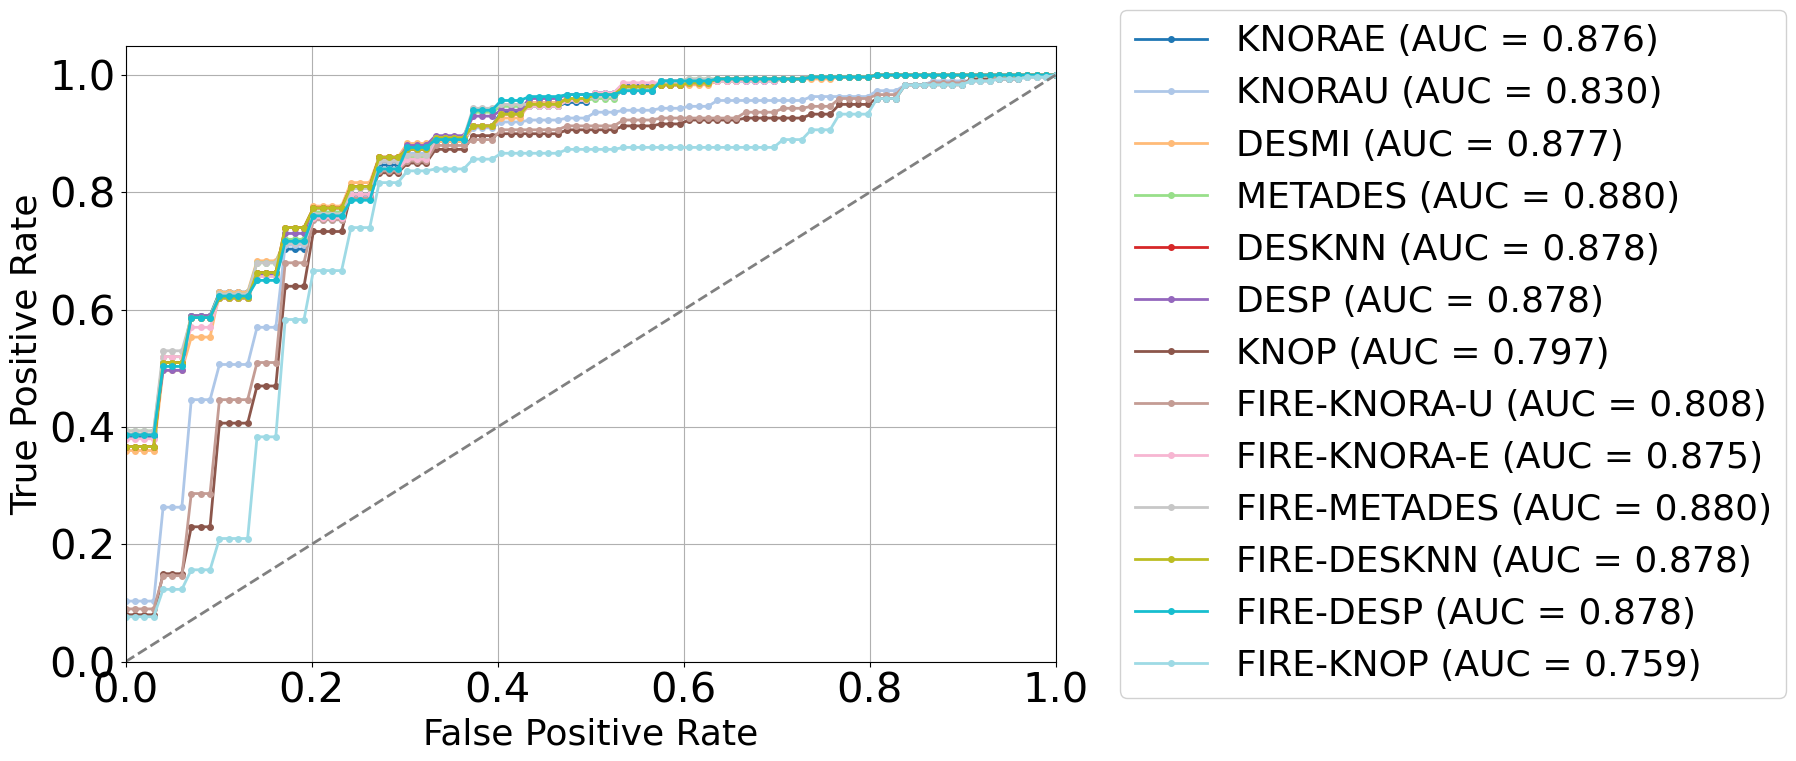

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

In [119]:
print('\nAverage Metrics over 10 Random States:')
for des_name, metrics in metric_sums_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores[des_name])
    std_precision = np.std(precision_scores[des_name])
    std_recall = np.std(recall_scores[des_name])
    std_f1 = np.std(f1_scores[des_name])
    avg_auc = np.mean(roc_aucs[des_name])
    print(f'{des_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

plot_combined_roc_curve(roc_curves, list(des_models.keys()))

Friedman Test Statistic: 7.481800391389399, p-value: 0.8242033385757975
Critical Difference: 5.769621047847687


<Figure size 1400x1000 with 0 Axes>

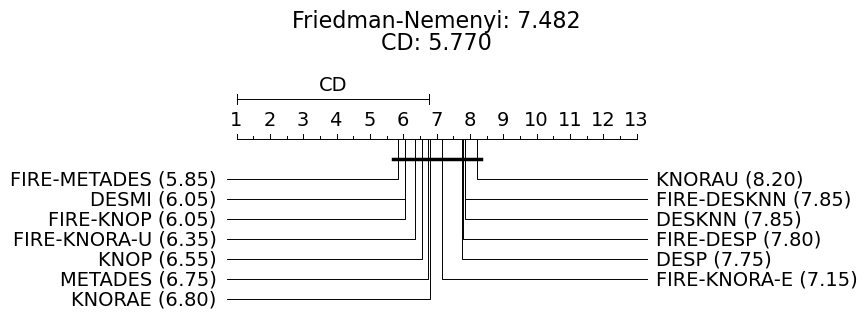

In [120]:
df = pd.DataFrame(accuracy_scores)
scores = [df[col].values for col in df.columns]

stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')

ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values

n_datasets = df.shape[0]
alpha = 0.05

cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')

classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]

plt.figure(figsize=(14, 10))

graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.xlabel('Classifiers')

plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()

### Explainability Analysis
Updated for the new classification task

In [121]:
# Update SHAP analysis for the new dataset
if not hasattr(np, 'bool'):
    np.bool = bool

random_state = 2
print(f"Processing for Random State: {random_state}")

X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
y = splitted_dataset[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

smote = SMOTE(random_state=random_state)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"Number of training labels after SMOTE: {Counter(y_res)}")
print(f"Number of test labels: {Counter(y_test)}")

# Train XGBoost model on all features
model = xgb.XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
model.fit(X_res, y_res)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

Processing for Random State: 2
Number of training labels after SMOTE: Counter({0: 66, 1: 66})
Number of test labels: Counter({0: 30, 1: 30})
Accuracy: 0.8000
Accuracy: 0.8000


In [123]:
def plot_shap_waterfall(instance_index, filename):
    shap_value = shap_values[instance_index]
    plt.figure(figsize=(14, 8))

    shap.plots.waterfall(shap_value, show=False)

    ax = plt.gca()

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=22)

    plt.tight_layout()

    plt.savefig(filename, format='svg')

    plt.close()

# Check the actual size of the dataset and use valid indices
print(f"Dataset size after preprocessing: {len(X_res)}")
print(f"SHAP values shape: {shap_values.shape}")

# Use valid indices within the dataset size
max_index = len(X_res) - 1
plot_shap_waterfall(0, "waterfall_plot_instance_0.svg")
plot_shap_waterfall(min(50, max_index), f"waterfall_plot_instance_{min(50, max_index)}.svg")

Dataset size after preprocessing: 132
SHAP values shape: (132, 124)


In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
shap.summary_plot(
    shap_values,
    X_res,
    plot_type="bar",
    feature_names=original_columns,
    show=False
)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=22)

plt.savefig("shap_summary_plot.svg", format='svg')
plt.close()

In [125]:
shap.initjs()

fig, ax = plt.subplots(figsize=(14, 8))

shap.summary_plot(
    shap_values,
    X_res,
    plot_type="dot",
    feature_names=original_columns,
    show=False
)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=22)

fig.savefig("shap_summary_dot_plot.svg", format='svg', bbox_inches='tight')

plt.close(fig)

In [ ]:
# Update decision tree visualization for new classification task
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree

random_state = 5

X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
y = splitted_dataset[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

smote = SMOTE(random_state=random_state)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"Number of training labels after SMOTE: {Counter(y_res)}")
print(f"Number of test labels: {Counter(y_test)}")

X_res = pd.DataFrame(X_res, columns=original_columns)
X_test = pd.DataFrame(X_test, columns=original_columns)

decision_tree_model = DecisionTreeClassifier(
    random_state=0,
    criterion='gini',
    max_depth=6,
    min_samples_leaf=10,
    min_samples_split=9
)
decision_tree_model.fit(X_res, y_res)

# Get class names based on unique values in target
unique_classes = sorted(y.unique())
class_names = [f'Class_{i}' for i in unique_classes]

plt.figure(figsize=(20, 14))
tree.plot_tree(
    decision_tree_model,
    feature_names=original_columns,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)

plt.savefig("decision_tree_plot.svg", format='svg')
plt.close()

print("Decision Tree plot saved as 'decision_tree_plot.svg'")

In [ ]:
# Generate tree rules with updated class names
tree_rules = export_text(
    decision_tree_model,
    feature_names=original_columns,
    max_depth=3
)

print("Decision rules for the tree (up to depth 3):")
print(tree_rules)

node_indicator = decision_tree_model.decision_path(X_test)

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:node_indicator.indptr[sample_id + 1]]

print(f"\nDecision path for sample {sample_id}:")
for node_id in node_index:
    if X_test.iloc[sample_id, decision_tree_model.tree_.feature[node_id]] <= decision_tree_model.tree_.threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"
    print(f"Node {node_id}: (X_test[{sample_id}, {decision_tree_model.tree_.feature[node_id]}] = {X_test.iloc[sample_id, decision_tree_model.tree_.feature[node_id]]}) "
          f"{threshold_sign} {decision_tree_model.tree_.threshold[node_id]}")

# Get prediction for a specific test sample
predicted_class = decision_tree_model.predict([X_test.iloc[sample_id]])
print(f"\nPredicted class for test sample {sample_id}: {predicted_class}")

Decision rules for the tree (up to depth 3):


NameError: name 'tree_rules' is not defined